In [55]:
import zipfile
import tarfile

import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import csv

import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

import torch
import numpy as np


import random
from tqdm import tqdm

In [56]:
backGroundMinLayer = 8
backGroundMaxLayer = 13
layerSoundChild = 16

In [57]:
asd = torch.zeros((3,5))

asd[1][1:3] = 6

#asd[0:2, 1:3] = 5
#asd
#torch.flip(asd, [-2])
#asd[1:3, 3] = 4
#asd[0][1:3] = 6
asd

tensor([[0., 0., 0., 0., 0.],
        [0., 6., 6., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [58]:
asd.size()[1]

5

In [59]:
objectLayer = {}
objectShape = {}
with open('CorrispondenzeOggettiClasse.csv', mode='r') as f:
    lines = f.readlines()
    lines[0] = '0;0;0\n'
for line in lines:
    keyValue = line.split(';')
    objectLayer[int(keyValue[0])] = int(keyValue[1])
    objectShape[int(keyValue[0])] = int(keyValue[2][:-1])

In [60]:
def checkSameBytes(firstBytes, secondBytes):
    for idx, b in enumerate(secondBytes):
        if firstBytes[idx] != b:
            return False
    return True

In [7]:
def instanceAllObjects(className, bytesArray, count, size):
    instanceList = []
    startByte = 0
    constructor = globals()[className]
    for o in range(0, count):
        instance = constructor()
        instance.fromBytes(bytesArray[startByte:startByte + size])
        startByte += size
        instanceList.append(instance)
    return instanceList

In [8]:
def addZeros(bytesArray, finalSize):
    if(len(bytesArray) < finalSize):
        missingBytes = finalSize - len(bytesArray)
        zero = 0
        zeroByte = zero.to_bytes(1, 'little')
        bytesArray = bytesArray + (zeroByte * missingBytes)
    return bytesArray  

In [9]:
def fromListToBytes(objects, finalSize):
    objectsBytes =  bytearray()
    if len(objects) > 0:
        objectsBytesLists = list(map(lambda o: o.toBytes(), objects))
        objectsBytes = objectsBytesLists[0]
        for ob in objectsBytesLists[1:]:
            objectsBytes += ob
    return addZeros(objectsBytes, finalSize)    
    

In [10]:
class ObjectBytes(ABC):
    @abstractmethod
    def toBytes(self):
        pass
    @abstractmethod
    def fromBytes(self, objectBytes):
        pass

In [11]:
class GameObject(ObjectBytes):
    
    def fromBytes(self, objectBytes):
        self.xPosition = int.from_bytes(objectBytes[:4],"little", signed = False)
        self.yPosition = int.from_bytes(objectBytes[4:8],"little", signed = False)
        self.xOriginalPosition = int.from_bytes(objectBytes[:4],"little", signed = False)
        self.yOriginalPosition = int.from_bytes(objectBytes[4:8],"little", signed = False)        
        self.middleTileX = True if (self.xPosition - 80) % 160 != 0 else False
        self.xPosition = (self.xPosition - 80) // 160
        self.middleTileY = True if (self.yPosition - 80) % 160 != 0 else False
        self.yPosition = (self.yPosition - 80) // 160
        self.padding = int.from_bytes(objectBytes[8:10],"little", signed = False)
        self.objectWidth = objectBytes[10]
        self.objectHeight = objectBytes[11]
        self.objectFlags = int.from_bytes(objectBytes[12:16],"little", signed = False)
        self.childObjectFlags = int.from_bytes(objectBytes[16:20],"little", signed = False)
        self.extendedData = int.from_bytes(objectBytes[20:24],"little", signed = False)
        self.objectType = int.from_bytes(objectBytes[24:26],"little", signed = False)
        self.childObjectType = int.from_bytes(objectBytes[26:28],"little", signed = False)
        self.linkID = int.from_bytes(objectBytes[28:30],"little", signed = False)
        self.soundEffect = int.from_bytes(objectBytes[30:32],"little", signed = False)
        self.layer = objectLayer[self.objectType] #MIO
        self.flagsType = int.from_bytes(objectBytes[12:16] + objectBytes[24:26],"little", signed = False) #MIO
        self.childFlagsType= int.from_bytes(objectBytes[16:20] + objectBytes[26:28],"little", signed = False) #MIO
        self.shape = objectShape[self.objectType] #MIO
        
    def fromValues(self, xPosition, yPosition, objectWidth, objectHeight, objectFlags, objectType, childObjectFlags, childObjectType, soundEffect, extendedData = 0):
        #Aggiungere gestione del middleTile
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.padding = 0
        self.objectWidth = objectWidth
        self.objectHeight = objectHeight
        self.objectFlags = objectFlags
        self.childObjectFlags = childObjectFlags
        self.objectType = objectType
        self.childObjectType = childObjectType
        self.linkID = 0 #TODO capire che fa sto coso
        self.extendedData = extendedData
        self.soundEffect = soundEffect
        
    
    def toBytes(self):
        xPositionBytes = (self.xPosition * 160) + 80
        yPositionBytes = (self.yPosition * 160) + 80
        if self.middleTileX:
            xPositionBytes +=80
        if self.middleTileY:
            yPositionBytes +=80
        xBytes = xPositionBytes.to_bytes(4, 'little')
        yBytes = yPositionBytes.to_bytes(4, 'little')
        padding = self.padding.to_bytes(2, 'little')
        width = self.objectWidth.to_bytes(1, 'little')
        height = self.objectHeight.to_bytes(1, 'little')
        flags = self.objectFlags.to_bytes(4, 'little')
        childObjectFlags = self.childObjectFlags.to_bytes(4, 'little')
        extendedData = self.extendedData.to_bytes(4, 'little')
        objectType = self.objectType.to_bytes(2, 'little')
        childObjectType = self.childObjectType.to_bytes(2, 'little')
        linkID = self.linkID.to_bytes(2, 'little')
        soundEffect = self.soundEffect.to_bytes(2, 'little')
        return xBytes + yBytes + padding + width + height + flags + childObjectFlags + extendedData + objectType + childObjectType + linkID + soundEffect
    
    def __str__(self):
        return 'Tipo:' + str(self.objectType) + '\nPosizione:(' + str(self.xPosition) + ',' + str(self.yPosition) + ')' \
            + '\nDimensioni:(' + str(self.objectWidth) + ',' + str(self.objectHeight) + ')' \
            + ('Ha figlio di tipo:' + str(self.childObjectType) if self.childObjectType != 65535 else 'non ha figlio') \
            + '\nflags: ' + str(self.objectFlags)\
            + ' posizione originale:' + str(self.xOriginalPosition) + ' ' + str(self.yOriginalPosition)

In [12]:
class FreestandingSoundEffect(ObjectBytes):
    layer = 17
    def fromBytes(self, soundBytes):
        self.effectType = soundBytes[0]
        self.xPosition = soundBytes[1]
        self.yPosition = soundBytes[2]
        self.padding = soundBytes[3]
        
    def fromValues(self,effectType, xPosition, yPosition):
        self.effectType = effectType
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.padding = 0
        
    def toBytes(self):
        effectType = self.effectType.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return effectType + xPosition + yPosition + padding

In [13]:
class SnakeNode(ObjectBytes):
    objectID = 127
    layer = 1
    def fromBytes(self, snakeNodeBytes):
        self.index = int.from_bytes(snakeNodeBytes[:2],"little", signed = False) #parte da zero
        self.direction = int.from_bytes(snakeNodeBytes[2:4],"little", signed = False)
        self.always100 = int.from_bytes(snakeNodeBytes[4:6],"little", signed = False)
        self.padding = int.from_bytes(snakeNodeBytes[6:8],"little", signed = False) 
        self.directionSnake = int.from_bytes(self.direction.to_bytes(4, 'little') + SnakeNode.objectID.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    def fromValues(index, direction):
        self.index = index
        self.direction = direction
        self.always100 = 100
        self.padding = 0 
        
    
    def toBytes(self):
        index = self.index.to_bytes(2, 'little')
        direction = self.direction.to_bytes(2, 'little')
        always100 = self.always100.to_bytes(2, 'little')
        padding = self.padding.to_bytes(2, 'little')
        return index + direction + always100 + padding

In [14]:
class SnakeBlockTrack(ObjectBytes):
    objectID = 84
    layer = 1
    def fromBytes(self, snakeBytes):
        self.linkID = snakeBytes[0] #sarà 0 1 2 3 4?
        self.nodeCount = snakeBytes[1]
        self.always1 = snakeBytes[2]
        self.padding = snakeBytes[3]
        self.snakeNodes = instanceAllObjects('SnakeNode', snakeBytes[4:], self.nodeCount, 8)
        
    def fromValues(self,linkID, snakeNodes):
        self.linkID = linkID
        self.snakeNodes = snakeNodes
        self.nodeCount = len(snakeNodes)
        self.always1 = 1
        self.padding = 0
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        snakeNodes = fromListToBytes(self.snakeNodes, 960)
        return linkID + nodeCount + always1 + padding + snakeNodes  

In [15]:
class ClearPipeNode(ObjectBytes):
    def fromBytes(self, clearPipeNodesBytes):
        self.unknownDirection = clearPipeNodesBytes[0]
        self.index = clearPipeNodesBytes[1]
        self.unKnowCoordinates = clearPipeNodesBytes[2]
        self.unKnowCoordinates2 = clearPipeNodesBytes[3]
        self.always2 = clearPipeNodesBytes[4]
        self.unknown = clearPipeNodesBytes[5] 
        self.always1 = clearPipeNodesBytes[6]
        self.unknown0123 = clearPipeNodesBytes[7]
        
    def toBytes(self):
        unknownDirection = self.unknownDirection.to_bytes(1, 'little')
        index = self.index.to_bytes(1, 'little')
        unKnowCoordinates = self.unKnowCoordinates.to_bytes(1, 'little')
        unKnowCoordinates2 = self.unKnowCoordinates2.to_bytes(1, 'little')
        always2 = self.always2.to_bytes(1, 'little')
        unknown = self.unknown.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        unknown0123 = self.unknown0123.to_bytes(1, 'little')
        return unknownDirection + index + unKnowCoordinates + unKnowCoordinates2 + always2 + unknown + always1 + unknown0123

In [16]:
class ClearPipe(ObjectBytes):
    def fromBytes(self, clearPipeBytes):
        self.linkID = clearPipeBytes[0]
        self.nodeCount = clearPipeBytes[1]
        self.always1 = clearPipeBytes[2]
        self.padding = clearPipeBytes[3]
        self.clearPipeNodes = instanceAllObjects('ClearPipeNode', clearPipeBytes[4:], self.nodeCount, 8)
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        clearPipeNodes = fromListToBytes(self.clearPipeNodes, 288)
        return linkID + nodeCount + always1 + padding + clearPipeNodes  

In [17]:
class PiranhaCreeperNode(ObjectBytes):
    def fromBytes(self, piranhaCreeperNodeBytes):
        self.always1 = piranhaCreeperNodeBytes[0] 
        self.direction = piranhaCreeperNodeBytes[1]
        self.always0_1 = piranhaCreeperNodeBytes[2]
        self.always0_2 = piranhaCreeperNodeBytes[3]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        always0_1 = self.always0_1.to_bytes(1, 'little')
        always0_2 = self.always0_2.to_bytes(1, 'little')
        return always1 + direction + always0_1 + always0_2

In [18]:
class PiranhaCreeperTrack(ObjectBytes):
    def fromBytes(self, piranhaCreeperTrackBytes):
        self.always1 = piranhaCreeperTrackBytes[0] 
        self.linkID = piranhaCreeperTrackBytes[1]
        self.nodeCount = piranhaCreeperTrackBytes[2]
        self.padding = piranhaCreeperTrackBytes[3]
        self.piranhaCreeperNodes = instanceAllObjects('PiranhaCreeperNode', piranhaCreeperTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        piranhaCreeperNodes = fromListToBytes(self.piranhaCreeperNodes, 80)
        return always1 + linkID + nodeCount + padding + piranhaCreeperNodes  

In [19]:
class ExpandingBlockNode(ObjectBytes):
    def fromBytes(self, expandingBlockNodeBytes):
        self.always1 = expandingBlockNodeBytes[0] 
        self.direction = expandingBlockNodeBytes[1]
        self.padding = expandingBlockNodeBytes[2:4] 
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding  

In [20]:
class ExpandingBlockTrack(ObjectBytes):
    def fromBytes(self, expandingBlockTrackBytes):
        self.always1 = expandingBlockTrackBytes[0] 
        self.linkID = expandingBlockTrackBytes[1]
        self.nodeCount = expandingBlockTrackBytes[2]
        self.padding = expandingBlockTrackBytes[3]    
        self.expandingBlockNodes = instanceAllObjects('ExpandingBlockNode', expandingBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        expandingBlockNodes = fromListToBytes(self.expandingBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + expandingBlockNodes      

In [21]:
class TrackBlockNode(ObjectBytes):
    def fromBytes(self, trackBlockNodeBytes):
        self.always1 = trackBlockNodeBytes[0]
        self.direction = trackBlockNodeBytes[1]
        self.padding = trackBlockNodeBytes[2:4]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding 

In [22]:
class TrackBlockTrack(ObjectBytes):
    def fromBytes(self, trackBlockTrackBytes):
        self.always1 = trackBlockTrackBytes[0] 
        self.linkID = trackBlockTrackBytes[1]
        self.nodeCount = trackBlockTrackBytes[2]
        self.padding = trackBlockTrackBytes[3]  
        self.trackBlockNodes = instanceAllObjects('TrackBlockNode', trackBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        trackBlockNodes = fromListToBytes(self.trackBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + trackBlockNodes  

In [23]:
class Tile(ObjectBytes):
    def fromBytes(self, tileBytes):
        self.xPosition = tileBytes[0]
        self.yPosition = tileBytes[1]
        self.tileID = tileBytes[2] 
        self.backgroundObjectID = tileBytes[3]
        
    def fromValues(xPosition, yPosition, tileID):
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.tileID = tileID 
        self.backgroundObjectID = 0
        
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        tileID = self.tileID.to_bytes(1, 'little')
        backgroundObjectID = self.backgroundObjectID.to_bytes(1, 'little')
        return xPosition + yPosition + tileID + backgroundObjectID
    
    def __str__(self):
        return str(self.xPosition) + ' ' + str(self.yPosition) + ' ' + str(self.tileID) + ' ' + str(self.backgroundObjectID) 

In [24]:
class Rail(ObjectBytes):
    layer = 7
    typeObject = 59
    def fromBytes(self, railBytes):
        self.padding = int.from_bytes(railBytes[:2],"little", signed = False) 
        self.hasObject = railBytes[2]
        self.xPosition = railBytes[3]
        self.yPosition = railBytes[4]
        self.trackType = railBytes[5]
        self.index = int.from_bytes(railBytes[6:8],"little", signed = False) 
        self.unknown2 = int.from_bytes(railBytes[8:10],"little", signed = False) 
        self.unknown3 = int.from_bytes(railBytes[10:12],"little", signed = False) 
        self.railDirection = int.from_bytes(self.trackType.to_bytes(4, 'little') + Rail.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    def fromValues(hasObject, xPosition, yPosition, trackType, index, railDirection):
        self.padding = int.from_bytes(railBytes[:2],"little", signed = False) 
        self.hasObject = railBytes[2]
        self.xPosition = railBytes[3]
        self.yPosition = railBytes[4]
        self.trackType = railBytes[5]
        self.index = int.from_bytes(railBytes[6:8],"little", signed = False) 
        self.unknown2 = int.from_bytes(railBytes[8:10],"little", signed = False) 
        self.unknown3 = int.from_bytes(railBytes[10:12],"little", signed = False) 
        self.railDirection = int.from_bytes(self.trackType.to_bytes(4, 'little') + Rail.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    
    def toBytes(self):
        padding = self.padding.to_bytes(2, 'little')
        hasObject = self.hasObject.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        trackType = self.trackType.to_bytes(1, 'little')
        index = self.index.to_bytes(2, 'little')
        unknown2 = self.unknown2.to_bytes(2, 'little')
        unknown3 = self.unknown3.to_bytes(2, 'little')
        return padding + hasObject + xPosition + yPosition + trackType + index + unknown2 + unknown3

In [25]:
class Icicle(ObjectBytes):
    typeObject = 118
    def fromBytes(self, icicleBytes):
        self.xPosition = icicleBytes[0]
        self.yPosition = icicleBytes[1]
        self.typeIcicle = icicleBytes[2]
        self.padding = icicleBytes[3]
        self.typeForMatrix =  int.from_bytes(self.typeIcicle.to_bytes(4, 'little') + Icicle.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
        
    def fromValues(xPosition, yPosition, typeIcicle):
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.tileID = tileID 
        self.padding = 0
            
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        typeIcicle = self.typeIcicle.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return xPosition + yPosition + typeIcicle + padding

In [26]:
def buildRail(matrix, x,y, rails = [], loop = False):  #ABBANDONATE LE TRACK
    cellValue = matrix[Rail.layer][y][x] = 0
    arrayValues = cellValue.to_bytes(6, 'little')
    typeObject = int.from_bytes(arrayValues[5:],"little", signed = False)
    direction = int.from_bytes(arrayValues[:4],"little", signed = False)
       
    

In [27]:
def buildSnake(matrix, xPosition, yPosition, snakes, objects):
    matrix[SnakeBlockTrack.layer][yPosition][xPosition:xPosition + 5] = 0 
    soundEffect = matrix[layerSoundChild][yPosition][xPosition]
    matrix[layerSoundChild][yPosition][xPosition] = 0
    extendedData = len(snakes) + 100 #todo controllare
    snakeObject = GameObject()
    snakeObject.fromValues(xPosition, yPosition, 5, 1, 100663360, 84, 0, 65535, soundEffect, extendedData)
    objects.append(snakeObject)
    
    xNode = xPosition + 5
    yNode = yPosition
    snakeNodes = []
    index = 0
    while(True):
        nodeCell = matrix[SnakeBlockTrack.layer][yNode][xNode]
        matrix[SnakeBlockTrack.layer][yNode][xNode] = 0
        
        arrayValues = nodeCell.to_bytes(6, 'little')
        direction = int.from_bytes(arrayValues[:4],"little", signed = False)
        nodeAssertion = int.from_bytes(arrayValues[5:],"little", signed = False)
        
        assert nodeAssertion != SnakeNode.objectID
        
        node = SnakeNode()
        node.fromValues(index, direction)
        index += 1
        if direction > 12: 
            break
        
        if node.direction == 1 or node.direction == 6 or node.direction == 8:#LEFT
            xNode -= 1
            continue
        if node.direction == 2 or node.direction == 10 or node.direction == 12:#RIGHT
            xNode += 1
            continue
        if node.direction == 3 or node.direction == 5 or node.direction == 9:   #DOWN
            yNode -= 1
            continue
        if node.direction == 4 or node.direction == 7 or node.direction == 11:#UP
            yNode += 1
            continue
    
     

In [120]:
class LevelArea(ObjectBytes):
    
    #def __init__(self):
    
    def fromBytes(self, levelBytes, isMain, startY = 0, endY = 0):
        self.isMain = isMain
        if isMain:
            self.startY = startY
            self.endY = endY
        self.courseTheme = levelBytes[0]
        self.autoScrollType = levelBytes[1]
        self.screenBoundaryFlags = levelBytes[2]
        self.levelHorientation = levelBytes[3]
        self.lavaWaterHeight = levelBytes[4]
        self.lavaWaterMode = levelBytes[5]
        self.lavaWaterSpeed = levelBytes[6]
        self.minimunLavaWaterHeight = levelBytes[7]
        self.rightBoundary = int.from_bytes(levelBytes[8:12],"little", signed = False) // 16
        self.topBoundary = int.from_bytes(levelBytes[12:16],"little", signed = False) // 16
        self.leftBoundary = int.from_bytes(levelBytes[16:20],"little", signed = False) // 16
        self.bottomBoundary = int.from_bytes(levelBytes[20:24],"little", signed = False) // 16
        self.areaFlags = int.from_bytes(levelBytes[24:28],"little", signed = False)
        self.objectCount = int.from_bytes(levelBytes[28:32],"little", signed = False)
        self.freeStandingSoundEffectCount = int.from_bytes(levelBytes[32:36],"little", signed = False)
        self.snakeBlockCount = int.from_bytes(levelBytes[36:40],"little", signed = False)
        self.clearPipeCount = int.from_bytes(levelBytes[40:44],"little", signed = False)
        self.piranhaCreeperCount = int.from_bytes(levelBytes[44:48],"little", signed = False)
        self.expandingBlockCount = int.from_bytes(levelBytes[48:52],"little", signed = False)
        self.trackBlockCount = int.from_bytes(levelBytes[52:56],"little", signed = False)
        self.alwaysZero = int.from_bytes(levelBytes[56:60],"little", signed = False)
        self.tileCount = int.from_bytes(levelBytes[60:64],"little", signed = False)
        self.railCount = int.from_bytes(levelBytes[64:68],"little", signed = False)
        self.icicleCount = int.from_bytes(levelBytes[68:72],"little", signed = False)
        
        
        
        objectsBytes = levelBytes[72:83272]
        self.objects = instanceAllObjects('GameObject', objectsBytes, self.objectCount, 32)
        
        
        soundEffectsBytes = levelBytes[83272:84472]
        self.soundEffects = instanceAllObjects('FreestandingSoundEffect', soundEffectsBytes, self.freeStandingSoundEffectCount, 4)
        
        
        snakesBytes = levelBytes[84472:89292]
        self.snakes = instanceAllObjects('SnakeBlockTrack', snakesBytes, 5, 964)
        
        
        clearPipeBytes = levelBytes[89292:147692]
        self.clearPipes = instanceAllObjects('ClearPipe', clearPipeBytes, self.clearPipeCount, 292)
        
        creeperBytes = levelBytes[147692:148532]
        self.creepers = instanceAllObjects('PiranhaCreeperTrack', creeperBytes, self.piranhaCreeperCount, 84)
        
        expandingBlockBytes = levelBytes[148532:148972]
        self.expandingBlocks = instanceAllObjects('ExpandingBlockTrack', expandingBlockBytes, self.expandingBlockCount, 44)
        
        trackBlockBytes = levelBytes[148972:149412]
        self.trackBlocks = instanceAllObjects('TrackBlockTrack', trackBlockBytes, self.trackBlockCount, 44)
        
        tilesBytes = levelBytes[149412:165412]
        self.tiles = instanceAllObjects('Tile', tilesBytes, self.tileCount, 4)
        
        railBytes = levelBytes[165412:183412]
        self.rails = instanceAllObjects('Rail', railBytes, self.railCount, 12)
        
        iCicleBytes = levelBytes[183412:184612]
        self.icicles = instanceAllObjects('Icicle', iCicleBytes, self.icicleCount, 4)
    
    
    def fromMatrix(self, matrix):  
        self.objects = []
        self.soundEffects = []
        self.snakes = []
        self.clearPipes = []
        self.creepers = []
        self.expandingBlocks = []
        self.expandingBlocks = []
        self.trackBlocks = []
        self.tiles = []
        self.rails = []
        self.icicles = []
        
        tileID = 0
        for layer in range(0, matrix.size()[0]):
            for y in range(0, matrix.size()[1]):
                for x in range(0, matrix.size()[2]): 
                    cellValue = matrix[layer][y][x]
                    if cellValue == 0:
                        continue
                    if cellValue == 7:
                        matrix[layer][y][x] = 0
                        terrain = Tile()
                        terrain.fromValues(x, y, tileID)
                        tileID += 1
                        continue
                        
                    
                        
                    if layer == FreestandingSoundEffect.layer:
                        matrix[layer][y][x] = 0
                        freeSound = FreestandingSoundEffect()
                        freeSound.fromValues(cellValue, x, y)
                        self.soundEffects.append(freeSound)
                        continue
                       
                
                    arrayValues = cellValue.to_bytes(6, 'little')
                    flags = int.from_bytes(arrayValues[:4],"little", signed = False)
                    typeObject = int.from_bytes(arrayValues[5:],"little", signed = False)
                    
                    
                    if typeObject == SnakeNode.objectID:
                        continue
                    
                    if typeObject == SnakeBlockTrack.objectID:
                        buildSnake(matrix, x, y, snakes, objects)
                        continue
                    
                    if typeObject == Icicle.typeObject:
                        matrix[layer][y][x] = 0
                        matrix[layer][y + 1][x] = 0
                        iCicle = Icicle()
                        iCicle.fromValues(x,y, int.from_bytes(arrayValues[:4],"little", signed = False))
                        self.icicles.append(iCicle)
                        continue
                        
                    
                        
                    
                    
    
    def calculateLayerBackground(self, matrix, objectMM, layer = -1):
        layer = layer if layer != -1 else objectMM.layer
        if layer < backGroundMinLayer or layer > backGroundMaxLayer:
            return layer
        error = False
        if objectMM.shape == 0:
            for i in range (0,objectMM.objectWidth):
                for j in range (0,objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + j][objectMM.xPosition + i] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
        else:
            for i in range (0,objectMM.objectWidth):
                if matrix[layer][objectMM.yPosition + objectMM.objectHeight - 1][objectMM.xPosition + i] != 0:
                    return self.calculateLayerBackground(matrix, objectMM, layer + 1)
            mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
            if objectMM.objectWidth % 2 == 0:
                for i in range (1, objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + i][mediumPoint] != 0 or matrix[layer][objectMM.yPosition + i][mediumPoint + 1] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
            else:
                for i in range (1, objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + i][mediumPoint] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
        return layer
    
    def toPytorchMatrix(self):
        if self.isMain:
            matrix = torch.zeros((18,28,255),dtype=torch.int64) #A quanto pare un livello ha un oggetto in posizione 27
            matrix[0][:self.startY, :5]  = 37 #Blocchi start
            matrix[0][:self.endY, self.rightBoundary - 10 : self.rightBoundary] = 37 #blocchi end

        else:
            matrix = torch.zeros((18,255,255),dtype=torch.int64)
            
        for terrain in self.tiles:
            assert matrix[1][terrain.yPosition][terrain.xPosition]  == 0, "occupato: " + str(matrix[1][terrain.yPosition][terrain.xPosition]) + 'posizione: (' + str(terrain.yPosition) + \
            ', ' + str(terrain.xPosition)
            matrix[1][terrain.yPosition][terrain.xPosition] = 7
            
        for sound in self.soundEffects:
            assert matrix[17][sound.yPosition][sound.xPosition]  == 0
            matrix[17][sound.yPosition][sound.xPosition] = sound.effectType
            
        #for rail in self.rails:
            #self.setRailTrack(matrix, rail)
            
        for iCicle in self.icicles:
            assert matrix[1][iCicle.yPosition][iCicle.xPosition] == 0
            assert matrix[1][iCicle.yPosition + 1][iCicle.xPosition] == 0
            matrix[1][iCicle.yPosition:(iCicle.yPosition + 2), iCicle.xPosition] = iCicle.typeForMatrix
            
        for objectMM in self.objects:
            if objectMM.layer == -1:
                continue
            layer = self.calculateLayerBackground(matrix, objectMM)
            if objectMM.objectType == SnakeBlockTrack.objectID:#è uno snake
                self.setSnakeTrack(matrix, objectMM)
                continue
                
            if objectMM.shape == 0: #Forma RECT
                
                if ((layer == 0 or layer == 1 or layer == 5 or layer == 6)and objectMM.objectFlags.to_bytes(4, 'little')[1] & 4 != 0): #se questo flag è attivo, probabilmente sta su una rail
                    continue
                xPosition = objectMM.xPosition
                yPosition = objectMM.yPosition
                width = objectMM.objectWidth
                height = objectMM.objectHeight
                
                if objectMM.objectType == 30 and height == 2:#nuvola del lakitu
                    height -=1
                
                if objectMM.objectType == 30: #Lakitu sta sopra nuvola
                    height -=1
                    yPosition += 1
                
                if objectMM.objectType == 42 or objectMM.objectType == 17: # è una koopaclowncar o ponte
                    height = 1
                    
                if objectMM.objectType == 32 or ((objectMM.objectType == 62 or objectMM.objectType == 77 or objectMM.objectType == 12) and width == 4): #ciccioni, bowser, boom boom, banzai bill
                    xPosition -=1
                
                versoX = 1
                versoY = 1
                if objectMM.objectType == 9:
                    height -= 1
                    rotation = (((objectMM.objectFlags.to_bytes(4, 'little')[0]<< 1) >> 6) & 3) << 5
                    if rotation == 96:
                        versoX = -1
                        versoY = -1
                    if rotation == 0:
                        appooggio = width
                        width = height
                        height = appooggio
                        versoY = -1
                    if rotation == 32:
                        versoX = -1
                        appooggio = width
                        width = height
                        height = appooggio 
                for i in range (0,width):
                    for j in range (0,height):
                        self.setCellMatrix(matrix, objectMM, layer, yPosition + (j * versoY), xPosition + (i * versoX), (i == 0 and j == 0))
                continue
                
                
            if objectMM.shape == 1: #Forma T
                for i in range (0,objectMM.objectWidth):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + i, i == 0)
                mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
                if objectMM.objectWidth % 2 == 0:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint - 1 : mediumPoint + 1] = objectMM.flagsType
                else:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint] = objectMM.flagsType
                continue
                
            if objectMM.shape == 2: #forma gentle
                rotation = objectMM.objectFlags.to_bytes(4, 'little')[2]
                if (objectMM.objectType == 87 and (rotation == 48 or rotation == 16)): 
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + objectMM.objectWidth - 1, True)
                    for i in range(1, objectMM.objectWidth - 1, 2):#discesa
                        matrix[objectMM.layer][(objectMM.yPosition + objectMM.objectHeight - (i // 2) - 2):(objectMM.yPosition + objectMM.objectHeight - (i // 2)), objectMM.xPosition + i : objectMM.xPosition + i + 2] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition, False)
                elif (objectMM.objectType == 87 and (rotation == 0 or rotation == 32)):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition, True)
                    for i in range(1, objectMM.objectWidth - 1, 2):#salita
                        matrix[objectMM.layer][(objectMM.yPosition + (i // 2)):(objectMM.yPosition + (i // 2)) + 2, objectMM.xPosition + i : objectMM.xPosition + i + 2] = objectMM.flagsType                    
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + objectMM.objectWidth - 1, False)
                continue
            
            
            
            
            if objectMM.shape == 3: #forma steep
                rotation = objectMM.objectFlags.to_bytes(4, 'little')[2]
                if (objectMM.objectType == 88 and (rotation == 48 or rotation == 16)) or (objectMM.objectType == 94 and rotation == 32): #discesa riflesso
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + objectMM.objectWidth - 1, True)
                    for i in range(1, objectMM.objectWidth - 1): #discesa da destra
                        matrix[objectMM.layer][(objectMM.yPosition + i - 1):(objectMM.yPosition + i + 1), objectMM.xPosition + objectMM.objectWidth - i - 1] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition , False)
                elif (objectMM.objectType == 88 and (rotation == 0 or rotation == 32)) or (objectMM.objectType == 94 and rotation == 16): #salita normale
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition, True)
                    for i in range(1, objectMM.objectWidth - 1): #salita
                        matrix[objectMM.layer][(objectMM.yPosition + i - 1):(objectMM.yPosition + i + 1), objectMM.xPosition + i] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + objectMM.objectWidth - 1 , False)
                continue
                    
            if objectMM.shape == 4: #forma T contraria
                for i in range (0,objectMM.objectWidth):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + i, i == 0)
                mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
                if objectMM.objectWidth % 2 == 0:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint : mediumPoint + 2] = objectMM.flagsType
                else:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint] = objectMM.flagsType
            
        return matrix
                
        
    def setSnakeTrack(self, matrix, objectMM):
        snakeBlock = self.snakes[objectMM.extendedData - 1]
        assert snakeBlock.nodeCount > 0
        for i in range (-objectMM.objectWidth // 2 + 1 if objectMM.objectWidth % 2 == 1 else 0, (objectMM.objectWidth // 2) + 1):
            self.setCellMatrix(matrix, objectMM, SnakeBlockTrack.layer, objectMM.yPosition, objectMM.xPosition + i, (i == 0))
        
        xCurrentTrack = objectMM.xPosition + objectMM.objectWidth // 2 + 1
        yCurrentTrack = objectMM.yPosition
        for node in snakeBlock.snakeNodes:
            assert matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack] == 0, 'occupato: ' + str(matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack]) + ' id:' + str(sb.linkID) + \
            '\nPosizione: ' + str(yCurrentTrack) + ' ' + str(xCurrentTrack)
            matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack] = node.directionSnake
            if node.direction == 1 or node.direction == 6 or node.direction == 8 or node.direction == 14:#LEFT
                xCurrentTrack -= 1
                continue
            if node.direction == 2 or node.direction == 10 or node.direction == 12 or node.direction == 13:#RIGHT
                xCurrentTrack += 1
                continue
            if node.direction == 3 or node.direction == 5 or node.direction == 9 or node.direction == 16:   #DOWN
                yCurrentTrack -= 1
                continue
            if node.direction == 4 or node.direction == 7 or node.direction == 11 or node.direction == 15:#UP
                yCurrentTrack += 1
                continue
    
    
    
    def setRailTrack(self, matrix, rail):
        assert matrix[Rail.layer][rail.yPosition][rail.xPosition] == 0
        matrix[Rail.layer][rail.yPosition][rail.xPosition] = rail.railDirection
    
    def setCellMatrix(self, matrix, objectMM, layer, yPosition, xPosition, childSoundCell):
        if yPosition >= 28:
            print(str(objectMM.objectType) + ' ' + str(objectMM.objectWidth) + ' ' + str(objectMM.objectHeight)\
        + ' ' + str(objectMM.middleTileX) + ' ' + str(objectMM.middleTileY) + ' ' + str(objectMM.yOriginalPosition) + ' ' + str(objectMM.xOriginalPosition) + ' ' + str(objectMM.linkID) + ' ' + str(childSoundCell)\
        + ' ' + str(yPosition) + ' ' + str(xPosition) + ' Flags: ' + str(objectMM.objectFlags))
        if matrix[layer][yPosition][xPosition] != 0 and (objectMM.objectType == 88 or objectMM.objectType == 87):
            return
        assert matrix[layer][yPosition][xPosition] == 0 or matrix[layer][yPosition][xPosition] == 7, 'occupato: ' + str(matrix[layer][yPosition][xPosition]) + ' ' + str(objectMM.objectType) + ' ' + str(objectMM.objectWidth) + ' ' + str(objectMM.objectHeight)\
        + ' ' + str(objectMM.middleTileX) + ' ' + str(objectMM.middleTileY) + ' ' + str(objectMM.yOriginalPosition) + ' ' + str(objectMM.xOriginalPosition) + ' ' + str(objectMM.linkID) + ' ' + str(childSoundCell)\
        + ' ' + str(yPosition) + ' ' + str(xPosition) + ' Flags: ' + str(objectMM.objectFlags)
        matrix[layer][yPosition][xPosition] = objectMM.flagsType
        if(childSoundCell):
            if(objectMM.childObjectType != 65535):
                assert matrix[15][yPosition][xPosition] == 0
                matrix[15][yPosition][xPosition] = objectMM.childFlagsType
            if(objectMM.soundEffect != 65535):
                assert matrix[layerSoundChild][yPosition][xPosition] == 0
                matrix[layerSoundChild][yPosition][xPosition] = objectMM.soundEffect
    
    def toBytes(self):
        courseTheme = self.courseTheme.to_bytes(1, 'little')
        autoScrollType = self.autoScrollType.to_bytes(1, 'little')
        screenBoundaryFlags = self.screenBoundaryFlags.to_bytes(1, 'little')
        levelHorientation = self.levelHorientation.to_bytes(1, 'little')
        lavaWaterHeight = self.lavaWaterHeight.to_bytes(1, 'little')
        lavaWaterMode = self.lavaWaterMode.to_bytes(1, 'little')
        lavaWaterSpeed = self.lavaWaterSpeed.to_bytes(1, 'little')
        minimunLavaWaterHeight = self.minimunLavaWaterHeight.to_bytes(1, 'little')
        
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        topBoundary = (self.topBoundary * 16).to_bytes(4, 'little')
        leftBoundary = (self.leftBoundary * 16).to_bytes(4, 'little')
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        bottomBoundary = self.bottomBoundary.to_bytes(4, 'little')
        areaFlags = self.areaFlags.to_bytes(4, 'little')
        objectCount = self.objectCount.to_bytes(4, 'little')
        freeStandingSoundEffectCount = self.freeStandingSoundEffectCount.to_bytes(4, 'little')
        snakeBlockCount = self.snakeBlockCount.to_bytes(4, 'little')
        clearPipeCount = self.clearPipeCount.to_bytes(4, 'little')
        piranhaCreeperCount = self.piranhaCreeperCount.to_bytes(4, 'little')
        expandingBlockCount = self.expandingBlockCount.to_bytes(4, 'little')
        trackBlockCount = self.trackBlockCount.to_bytes(4, 'little')
        alwaysZero = self.alwaysZero.to_bytes(4, 'little')
        tileCount = self.tileCount.to_bytes(4, 'little')
        railCount = self.railCount.to_bytes(4, 'little')
        icicleCount = self.icicleCount.to_bytes(4, 'little')
        returnBytes = courseTheme + autoScrollType + screenBoundaryFlags + levelHorientation + lavaWaterHeight + lavaWaterMode + lavaWaterSpeed + minimunLavaWaterHeight  \
               + rightBoundary + topBoundary + leftBoundary + bottomBoundary + areaFlags + objectCount + freeStandingSoundEffectCount + snakeBlockCount + clearPipeCount \
               + piranhaCreeperCount + expandingBlockCount + trackBlockCount + alwaysZero + tileCount + railCount + icicleCount
        objectsBytes = fromListToBytes(self.objects, 83200)
        soundEffectsBytes = fromListToBytes(self.soundEffects, 1200)
        snakesBytes = fromListToBytes(self.snakes, 4820)
        clearPipeBytes = fromListToBytes(self.clearPipes, 58400)
        creeperBytes = fromListToBytes(self.creepers, 840)
        expandingBlockBytes = fromListToBytes(self.expandingBlocks, 440)
        trackBlockBytes = fromListToBytes(self.trackBlocks, 440)
        tilesBytes = fromListToBytes(self.tiles, 16000)
        railBytes = fromListToBytes(self.rails, 18000)
        iCicleBytes = fromListToBytes(self.icicles, 1200)
        return returnBytes +  objectsBytes + soundEffectsBytes + snakesBytes + clearPipeBytes + creeperBytes + expandingBlockBytes + trackBlockBytes + tilesBytes + railBytes + iCicleBytes
        

In [68]:
class Header(ObjectBytes):
    def fromBytes(self, headerBytes):
        self.startY = headerBytes[0]
        self.endY = headerBytes[1]
        self.goalXx100 = int.from_bytes(headerBytes[2:4],"little", signed = False)
        self.timeLimit = int.from_bytes(headerBytes[4:6],"little", signed = False)
        self.targetAmountClearCondition = int.from_bytes(headerBytes[6:8],"little", signed = False)
        self.year = int.from_bytes(headerBytes[8:10],"little", signed = False)
        self.month = headerBytes[10]
        self.day = headerBytes[11]
        self.hour = headerBytes[12]
        self.minute = headerBytes[13]
        self.customAutoscrollSpeed = headerBytes[14]
        self.clearConditionType = headerBytes[15]
        self.clearConditionObject = int.from_bytes(headerBytes[16:20],"little", signed = False)
        self.gameVersion = int.from_bytes(headerBytes[20:24],"little", signed = False)
        self.levelFlags = int.from_bytes(headerBytes[24:28],"little", signed = False)
        self.clearCheckTries = int.from_bytes(headerBytes[28:32],"little", signed = False)
        self.clearCheckTime = int.from_bytes(headerBytes[32:36],"little", signed = False)
        self.creationID = int.from_bytes(headerBytes[36:40],"little", signed = False)
        self.uploadID = headerBytes[40:48]
        self.gameVersionCheck = headerBytes[48:52]
        self.padding = headerBytes[52:240]
        self.unknow2 = headerBytes[240]
        self.gameStyle = headerBytes[241:244]
        self.courseName = headerBytes[244:310]#wchar16
        self.courseDescription = headerBytes[310:512]
        
    def toBytes(self):
        startY = self.startY.to_bytes(1, 'little')
        endY = self.endY.to_bytes(1, 'little')
        goalXx100 = self.goalXx100.to_bytes(2, 'little')
        timeLimit = self.timeLimit.to_bytes(2, 'little')
        targetAmountClearCondition = self.targetAmountClearCondition.to_bytes(2, 'little')
        year = self.year.to_bytes(2, 'little')
        month = self.month.to_bytes(1, 'little')
        day = self.day.to_bytes(1, 'little')
        hour = self.hour.to_bytes(1, 'little')
        minute = self.minute.to_bytes(1, 'little')   
        customAutoscrollSpeed = self.customAutoscrollSpeed.to_bytes(1, 'little') 
        clearConditionType = self.clearConditionType.to_bytes(1, 'little') 
        clearConditionObject = self.clearConditionObject.to_bytes(4, 'little') 
        gameVersion = self.gameVersion.to_bytes(4, 'little')
        levelFlags = self.levelFlags.to_bytes(4, 'little')
        clearCheckTries = self.clearCheckTries.to_bytes(4, 'little')
        clearCheckTime = self.clearCheckTime.to_bytes(4, 'little')
        creationID = self.creationID.to_bytes(4, 'little')
        unknow2 = self.unknow2.to_bytes(1, 'little')
        
        return startY + endY + goalXx100 + timeLimit + targetAmountClearCondition + year + month + day + hour + minute + customAutoscrollSpeed + clearConditionType \
               + clearConditionObject + gameVersion + levelFlags + clearCheckTries + clearCheckTime + creationID + self.uploadID \
               + self.gameVersionCheck + self.padding + unknow2 + self.gameStyle + self.courseName + self.courseDescription

In [43]:
class MarioMaker2File(ObjectBytes):
    def fromBytes(self, fileBytes):
        self.gameVersion = fileBytes[:4]
        self.gameVersion2 = fileBytes[4:6]
        self.padding = fileBytes[6:8]
        self.CRC32 = fileBytes[8:12]
        self.SCDL = fileBytes[12:16]
        self.header = Header()
        self.header.fromBytes(fileBytes[16:528])
        self.mainLevelArea = LevelArea()
        self.mainLevelArea.fromBytes(fileBytes[528:188656], True, self.header.startY, self.header.endY)
        self.subLevelArea = LevelArea()
        self.subLevelArea.fromBytes(fileBytes[188656:376784], False)
        self.cryptoCfg = fileBytes[376784:]#non ne sono sicuro
        
    def toBytes(self):
        return self.gameVersion + self.gameVersion2 + self.padding + self.CRC32 + self.SCDL + addZeros(self.header.toBytes(), 512) + addZeros(self.mainLevelArea.toBytes(), 188128) + addZeros(self.subLevelArea.toBytes(), 188128) + self.cryptoCfg

In [61]:
levelFolder = Path("levels/")
levelsDownloaded = [f for f in listdir(levelFolder) if isfile(join(levelFolder, f))]
decryptLevelFilteredFolder = Path("levels/filtered/")
levelsDecrypted = [f for f in listdir(decryptLevelFilteredFolder) if isfile(join(decryptLevelFilteredFolder, f))]

In [62]:

levelsFiltered = []

In [63]:
levelsFilteredFile = Path("levelsFiltered.txt")
if levelsFilteredFile.is_file():
    with open(levelsFilteredFile, "r") as f:
        levelsFiltered = f.read().splitlines()

In [64]:
levelsToLoad = levelsDecrypted[:] if levelsDecrypted else levelsFiltered[:] if levelsFiltered else levelsDownloaded[:]

In [82]:
marioMakerLevels = []
levelsFiltered = []
levelsSet = set()
for levelName in tqdm(levelsToLoad):
    if not levelsDecrypted:
        filePath = join(levelFolder, levelName)
        if levelName[-4:] == '.zip':
            archive = zipfile.ZipFile(filePath, 'r')
            leveldata = archive.read('course_data_000.bcd')
            archive.close()
            with open('tools/tmp/course_data_000.bcd', 'wb') as f:
                f.write(leveldata)
        else:
            archive = tarfile.open(filePath, 'r')
            archive.extract('course_data_000.bcd', path="tools/tmp/")
            archive.close()
        !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
        with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
            leveldata = f.read()
    else:
        filePath = join(decryptLevelFilteredFolder ,levelName)
        with open(filePath, 'rb') as f:
            leveldata = f.read()
    level = MarioMaker2File()
    level.fromBytes(leveldata)
    if level.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    if level.header.creationID in levelsSet:
        os.remove(filePath)
        continue
    levelsSet.add(level.header.creationID)
    marioMakerLevels.append(level)
    levelsFiltered.append(levelName)
    if not levelsDecrypted:
        with open(join(decryptLevelFilteredFolder, levelName[:-4] + '.bcd'), 'wb') as f:
            f.write(leveldata)

100%|████████████████████████████████████████████████████████████████████████████| 13972/13972 [03:30<00:00, 66.51it/s]


In [ ]:
with open("levelsFiltered.txt", "w") as outfile:
    outfile.write("\n".join(levelsFiltered))

In [ ]:
for l in marioMakerLevels:
    levelsSet.add(l.header.creationID)

In [ ]:
len(levelsSet)

In [ ]:
for lmm in marioMakerLevels:
    for o in lmm.mainLevelArea.objects:
        if  (o.yPosition == 0) and not o.middleTileY:
            print(o)
            print(o.middleTileY)
            print(o.middleTileX)
            print(lmm.header.courseName.decode("utf-16"))

In [ ]:
archive = zipfile.ZipFile(join(levelFolder, 'flying_ghosthouse__70.zip'), 'r')
leveldata = archive.read('course_data_000.bcd')
archive.close()
with open('tools/tmp/course_data_000.bcd', 'wb') as f:
    f.write(leveldata)

In [ ]:
len(leveldata)

In [ ]:
!.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd

In [ ]:
with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
    leveldata = f.read()

In [ ]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)
len(testM.toBytes())

In [ ]:
for t in testM.mainLevelArea.tiles:
    if t.backgroundObjectID != 0:
        print(t.backgroundObjectID)

In [ ]:
checkSameBytes(leveldata, testM.toBytes())

In [ ]:
testM.mainLevelArea.expandingBlockCount

In [ ]:
testM.header.gameStyle.decode("utf-8")

In [ ]:
testM.header.courseName.decode("utf-16")[:9]

In [ ]:
testM.header.courseName.decode("utf-16").find('\x00')

In [ ]:
a = testM.toBytes()
print(len(a))
for idx, b in enumerate(leveldata):
    if a[idx] != b:
        print('porco dio')
        print(idx)
        break

In [ ]:
CryptoCfg

In [ ]:
courseName.decode("utf-16")

In [ ]:
courseDescription.decode("utf-16")

In [ ]:
gameStyle.decode("utf-8")

In [ ]:
'3W\x00'.rstrip('\x00')

In [ ]:
testM.header.gameStyle.decode("utf-8") == '3W\x00'

In [ ]:
for o in testM.mainLevelArea.objects:
    #print(o.objectType)
    if o.objectType == 26:
        print('ok')

In [ ]:
sampling = random.choices(levelsDownloaded, k=100)

In [45]:
levelsError = 0
for levelName in tqdm(levelsDownloaded):
    if levelName[-4:] == '.zip':
        archive = zipfile.ZipFile(join(levelFolder, levelName), 'r')
        leveldata = archive.read('course_data_000.bcd')
        archive.close()
        with open('tools/tmp/course_data_000.bcd', 'wb') as f:
            f.write(leveldata)
    else:
        archive = tarfile.open(join(levelFolder, levelName), 'r')
        archive.extract('course_data_000.bcd', path="tools/tmp/")
        archive.close()
    !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
    with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
        leveldata = f.read()
    testM = MarioMaker2File()
    
    if testM.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    a = testM.toBytes()
    for idx, b in enumerate(leveldata):
        if a[idx] != b:
            levelsError += 1
            print(testM.header.gameStyle.decode("utf-8"))
            print(testM.header.courseName.decode("utf-16"))
            print(levelName)
            print(idx)
            print('--------********')
            print(a[idx])
            print(b)
            break


  0%|                                                                                        | 0/31502 [00:00<?, ?it/s]


TypeError: MarioMaker2File() takes no arguments

In [ ]:
levelsError

In [121]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)
asd = testM.mainLevelArea.toPytorchMatrix()[0]
torch.set_printoptions(edgeitems=60)
asd

tensor([[          37,           37,           37,           37,           37,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
          ...,            0,            0,          

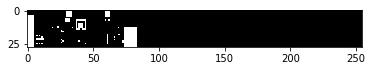

In [106]:
plt.imshow(torch.flip(asd, [-2]), cmap='gray', vmin=0, vmax=1)

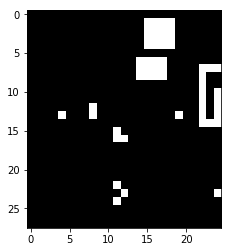

In [107]:
plt.imshow(torch.flip(asd[:,15:40], [-2]), cmap='gray', vmin=0, vmax=1)

In [183]:
for levelMM in tqdm(marioMakerLevels):
    levelMM.mainLevelArea.toPytorchMatrix()

 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [00:00<00:00, 27.80it/s]

bene dai


AssertionError: occupato: tensor(180489289924) 62 2 2 True True 2560 20960 5 True 15 130

In [122]:
marioMakerLevels = []
levelsFiltered = []
levelsSet = set()
for levelName in tqdm(levelsToLoad):
    if not levelsDecrypted:
        filePath = join(levelFolder, levelName)
        if levelName[-4:] == '.zip':
            archive = zipfile.ZipFile(filePath, 'r')
            leveldata = archive.read('course_data_000.bcd')
            archive.close()
            with open('tools/tmp/course_data_000.bcd', 'wb') as f:
                f.write(leveldata)
        else:
            archive = tarfile.open(filePath, 'r')
            archive.extract('course_data_000.bcd', path="tools/tmp/")
            archive.close()
        !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
        with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
            leveldata = f.read()
    else:
        filePath = join(decryptLevelFilteredFolder ,levelName)
        with open(filePath, 'rb') as f:
            leveldata = f.read()
    level = MarioMaker2File()
    level.fromBytes(leveldata)
    if level.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    if level.header.creationID in levelsSet:
        os.remove(filePath)
        continue
    levelsSet.add(level.header.creationID)
    marioMakerLevels.append(level)
#     tSet = set()
#     oSet = set()
#     for terrain in level.mainLevelArea.tiles:
#         tSet.add((terrain.xPosition, terrain.yPosition))
#         #print(str(terrain))
#         oSet.add((objectMM.xPosition, objectMM.yPosition))
        
#         if (objectMM.xPosition, objectMM.yPosition) in tSet and objectMM.layer == 1:
#             print(objectMM)
        
        
    
#     print(tSet.intersection(oSet))
    
    
    print(level.header.courseName.decode("utf-16"))
    print(levelName)
    level.mainLevelArea.toPytorchMatrix()

  0%|                                                                                | 4/13971 [00:00<10:29, 22.20it/s]

                                 
.bcd
.                                
._12720.bcd
0-1 Strawberry Marshmallow       
0-1_strawberry_marshmallow_13844.bcd
0-2 The Wind Rises               
0-2_the_wind_rises_15637.bcd


  0%|                                                                                | 8/13971 [00:00<09:52, 23.56it/s]

000                              
000_3523.bcd
001                              
001_2447.bcd
001                              
001_4583.bcd
007 - Bond, Mario Bond ♪         
007_-_bond_mario_bond__2958.bcd
00                               
00_12889.bcd
00                               
00_4633.bcd
01castle                         
01castle_4415.bcd


  0%|                                                                               | 14/13971 [00:00<09:52, 23.57it/s]

01flyinghouse                    
01flyinghouse_4452.bcd
01Forest                         
01forest_4431.bcd
01ghost                          
01ghost_4139.bcd
01                               
01_12890.bcd
01                               
01_721.bcd
01 Bordel dans le desert         
01_bordel_dans_le_desert_4453.bcd


  0%|                                                                               | 18/13971 [00:00<10:11, 22.83it/s]

03: Kleiner Abenteuer-Dschungel  
03_kleiner_abenteuer-dschungel_878.bcd
05:00 AM                         
05_00_am_12100.bcd
099                              
099_13632.bcd
0_0              d               

  0%|▏                                                                              | 25/13971 [00:00<08:35, 27.07it/s]


0_0d_12647.bcd
0                                
0_2849.bcd
0 Degrees Shellsius #TS #ST      
0_degrees_shellsius_ts_st_11763.bcd
1-1.exe has encountered an error 
1-1.exe_has_encountered_an_error_737.bcd
1-1but it autoscrolls vertically 
1-1but_it_autoscrolls_vertically_10902.bcd
1-1 1-2                          
1-1_1-2_511.bcd
1-1                              

  0%|▏                                                                              | 28/13971 [00:01<10:29, 22.14it/s]


1-1_12888.bcd
1-1                              
1-1_178.bcd
1-1                              
1-1_2545.bcd
1-1                              
1-1_5129.bcd


  0%|▏                                                                              | 32/13971 [00:01<10:09, 22.88it/s]

1-1                              
1-1_6168.bcd
1-1 Appel Wood Valley            
1-1_appel_wood_valley_2963.bcd
1-1 but ...?     ist             
1-1_but_..._ist_2697.bcd
1-1 but in a nintedo switch      
1-1_but_in_a_nintedo_switch_12223.bcd
1-1 but its on and off           

  0%|▏                                                                              | 35/13971 [00:01<10:41, 21.73it/s]


1-1_but_its_on_and_off_12337.bcd
1-1 But It's Played By A Goomba  
1-1_but_it_s_played_by_a_goomba_10551.bcd
1-1, but it's shaky              

  0%|▏                                                                              | 38/13971 [00:01<14:12, 16.33it/s]


1-1_but_it_s_shaky_13985.bcd
1-1 but Mother Nature is MAD!    
1-1_but_mother_nature_is_mad__2720.bcd
1-1 but this joke is dead :(     
1-1_but_this_joke_is_dead__8179.bcd
1-1 but with an extra twist      

  0%|▏                                                                              | 40/13971 [00:02<21:06, 11.00it/s]


1-1_but_with_an_extra_twist_4023.bcd
1-1 but with a twist             
1-1_but_with_a_twist_2394.bcd
1-1 Deluxe (NES REMASTER) !!     
1-1_deluxe_nes_remaster__11875.bcd


  0%|▎                                                                              | 45/13971 [00:02<19:22, 11.98it/s]

1-1 Flipped On Its Side! 0s) nt! 
1-1_flipped_on_its_side_0s_nt__4041.bcd
1-1 Freewheelin  mb's Blues e    
1-1_freewheelinmb_s_bluese_15011.bcd
1-1 Glitch Wall  -1 Remake       
1-1_glitch_wall-1_remake_4421.bcd
1-1  goomba hills  (5 starcoins) 
1-1_goomba_hills_5_starcoins__13736.bcd
1-1 Grassy Goomba Grounds ds     
1-1_grassy_goomba_groundsds_13483.bcd


  0%|▎                                                                              | 50/13971 [00:02<14:36, 15.89it/s]

1-1を壊さないで！！　Lakitu Breaks 1-1    
1-1_lakitu_breaks_1-1_11651.bcd
1-1 Leaving Home                 
1-1_leaving_home_2863.bcd
1-1 Mario 3                      
1-1_mario_3_12722.bcd
1-1 Mario Bros.: A New Journey   
1-1_mario_bros._a_new_journey_14350.bcd
1-1: Muncher Mines               
1-1_muncher_mines_5058.bcd


  0%|▎                                                                              | 56/13971 [00:02<12:59, 17.86it/s]

1-1: Mushroom Fields Forever     
1-1_mushroom_fields_forever_14403.bcd
1-1: Mystical Mushrooms.         
1-1_mystical_mushrooms._12384.bcd
1-1 New Super Mario Bros 2       
1-1_new_super_mario_bros_2_13492.bcd
1-1 Offical Nintendo Autoscroll  
1-1_offical_nintendo_autoscroll_5340.bcd
1-1 On/Off Hill  ction           
1-1_on_off_hillction_1085.bcd


  0%|▎                                                                              | 59/13971 [00:03<12:38, 18.34it/s]

1-1 Platform Plains              
1-1_platform_plains_13414.bcd
1-1 Remastered                   
1-1_remastered_10783.bcd
1-1 Remix                        
1-1_remix_557.bcd
1-1 (SMB 3) Christmas Special    
1-1_smb_3_christmas_special_7120.bcd


  0%|▎                                                                              | 62/13971 [00:03<12:40, 18.29it/s]

1-1 SMB                          
1-1_smb_451.bcd
1-1: Spinjump Valley             
1-1_spinjump_valley_4380.bcd
1-1 Super Mario Bros. 2          
1-1_super_mario_bros._2_12781.bcd


  0%|▍                                                                              | 68/13971 [00:03<15:35, 14.86it/s]

1-1 the crazy woods e wege       
1-1_the_crazy_woodse_wege_1316.bcd
1-1 without the ground           
1-1_without_the_ground_6808.bcd
1-1 Without Touching the Ground  
1-1_without_touching_the_ground_2164.bcd
1-1?                             
1-1__1164.bcd


  1%|▍                                                                              | 70/13971 [00:03<14:42, 15.75it/s]

1-2.exe has encountered an ěřŕôŕ 
1-2.exe_has_encountered_an__876.bcd
1-2 ノコノコレジデンス -Troopa Town-      
1-2_-troopa_town-_10277.bcd
1-2                              
1-2_10813.bcd
1-2                              
1-2_1961.bcd
1-2 "3 pièces dans 3 pièces"     
1-2_3_pi_ces_dans_3_pi_ces__1393.bcd


  1%|▍                                                                              | 73/13971 [00:04<15:15, 15.18it/s]

1-2                              
1-2_5130.bcd
1-2 but without ground           
1-2_but_without_ground_8587.bcd
1-2 Deluxe (NES REMASTER) Level) 
1-2_deluxe_nes_remaster_level__9001.bcd


  1%|▍                                                                              | 78/13971 [00:04<15:52, 14.59it/s]

1-2 Easy Ocean   u               
1-2_easy_oceanu_11055.bcd
1-2 Highwater    mb's Blues e    
1-2_highwatermb_s_bluese_15010.bcd
1-2: King Boboboomboom's Cavern  
1-2_king_boboboomboom_s_cavern_5059.bcd


  1%|▍                                                                              | 80/13971 [00:04<16:38, 13.92it/s]

1-2 Love never dies #Bakedpotato 
1-2_love_never_dies_bakedpotato_14743.bcd
1-2 Mushroom Sky                 
1-2_mushroom_sky_14371.bcd
1-2: Pesky Pipelines.            
1-2_pesky_pipelines._12340.bcd


  1%|▍                                                                              | 82/13971 [00:05<29:30,  7.85it/s]

1-2 Piranha Pipe Grotto          
1-2_piranha_pipe_grotto_2950.bcd
1-2 Slippery Slope Slide [30s] ] 
1-2_slippery_slope_slide_30s__14465.bcd


  1%|▌                                                                              | 89/13971 [00:05<22:50, 10.13it/s]

1-2 SMB                          
1-2_smb_452.bcd
1-2 Taking It Back               
1-2_taking_it_back_4496.bcd
1-2 The 76 Strip   w Zealand     
1-2_the_76_stripw_zealand_15248.bcd
1-2: The Long and Winding Roots  
1-2_the_long_and_winding_roots_14415.bcd
1-3 カラフル空中庭園 -Shiny Sky Garden-  
1-3_-shiny_sky_garden-_10387.bcd
1-3                              
1-3_5131.bcd
1-3: Across the Caps             
1-3_across_the_caps_14386.bcd
1-3 Deluxe (NES REMASTER) Level) 
1-3_deluxe_nes_remaster_level__11869.bcd


  1%|▌                                                                              | 92/13971 [00:05<21:49, 10.60it/s]

1-3 Flight School                
1-3_flight_school_4497.bcd
1-3 Kirstie's Serene Swim m ! !  
1-3_kirstie_s_serene_swimm__2584.bcd
1-3: Lord Kiavik's Demise l ern  
1-3_lord_kiavik_s_demiselern_5060.bcd


  1%|▌                                                                              | 95/13971 [00:06<21:09, 10.93it/s]

1-3 Mushroom Heights  s          
1-3_mushroom_heightss_13521.bcd
1-3 mushroom tower until the sky 
1-3_mushroom_tower_until_the_sky_13797.bcd


  1%|▌                                                                              | 99/13971 [00:06<21:19, 10.84it/s]

1-3 Piranha Plains               
1-3_piranha_plains_13765.bcd
1-3 Roll on John mb's Blues e    
1-3_roll_on_johnmb_s_bluese_15009.bcd
1-3 Sky Ruins                    
1-3_sky_ruins_14326.bcd
1-3 SMB                          

  1%|▌                                                                             | 101/13971 [00:06<18:23, 12.57it/s]


1-3_smb_453.bcd
1-3 Snowshroom Summit            
1-3_snowshroom_summit_3304.bcd


  1%|▌                                                                             | 103/13971 [00:06<24:21,  9.49it/s]

1-3 Spikeball Tower              
1-3_spikeball_tower_13394.bcd
1-3: Stiletto Skys. rs           
1-3_stiletto_skys.rs_12354.bcd
1-3 Submerged Obsidian           
1-3_submerged_obsidian_13741.bcd


  1%|▌                                                                             | 107/13971 [00:07<21:06, 10.95it/s]

1-4 ブンブントンネル -Boom Boom Tunnel-  
1-4_-boom_boom_tunnel-_10318.bcd
1-4 - The Floor is Goombas ) ..! 
1-4_-_the_floor_is_goombas_..__7419.bcd
1-4                              
1-4_5132.bcd


  1%|▌                                                                             | 109/13971 [00:07<19:46, 11.69it/s]

1-4 Bodacious Boot Dash [20s]    
1-4_bodacious_boot_dash_20s__14449.bcd
1-4: Boom Boom's Seesaw Shrooms  
1-4_boom_boom_s_seesaw_shrooms_5037.bcd


  1%|▌                                                                             | 111/13971 [00:07<19:27, 11.87it/s]

1-4 Deep Breathe                 
1-4_deep_breathe_4498.bcd
1-4 Fiery Fortress               
1-4_fiery_fortress_11106.bcd
1-4: Sizzle and Swing  Climb     
1-4_sizzle_and_swing_climb_13013.bcd


  1%|▋                                                                             | 113/13971 [00:07<18:42, 12.34it/s]

1-4 Sky Platforms ms in the sky  
1-4_sky_platformsms_in_the_sky_14372.bcd
1-4: Underground Fungi Fortress. 
1-4_underground_fungi_fortress._12385.bcd


  1%|▋                                                                             | 115/13971 [00:08<27:49,  8.30it/s]

1-5: Basidiomycota Bastion.      
1-5_basidiomycota_bastion._12376.bcd
1-5 Clown Amusement Park         

  1%|▋                                                                             | 117/13971 [00:08<28:46,  8.03it/s]


1-5_clown_amusement_park_14791.bcd
1-5 Larry's Skewering Castle     
1-5_larry_s_skewering_castle_13400.bcd


  1%|▋                                                                             | 120/13971 [00:08<29:20,  7.87it/s]

1-5 Sky Castle   astle           
1-5_sky_castleastle_14325.bcd
1-6: Mushroom Meltdown           
1-6_mushroom_meltdown_12355.bcd
1-6　おどる わかめの うみのなか　Seaweed Swim  
1-6_seaweed_swim_7497.bcd


  1%|▋                                                                             | 125/13971 [00:08<20:36, 11.20it/s]

1-7 Bunte Dimensionen            
1-7_bunte_dimensionen_2982.bcd
1-7　おなかがすいた おはながさいた　Foodie Field 
1-7_foodie_field_8221.bcd
1-7 Yoshi Fun                    
1-7_yoshi_fun_4501.bcd
1-8 Bring it back 2              
1-8_bring_it_back_2_4502.bcd
1-9 Ship Has Flight              
1-9_ship_has_flight_4503.bcd
1-A: Submerged Shiitake          
1-a_submerged_shiitake_12352.bcd


  1%|▋                                                                             | 129/13971 [00:09<27:14,  8.47it/s]

1-B: Glomeromycota Airship       
1-b_glomeromycota_airship_12371.bcd
1-S: VENDETTA!   s Demise l ern  
1-s_vendetta_s_demiselern_5061.bcd
1-ups galore                     
1-ups_galore_5653.bcd
1-城　ほうだいリフト のりほうだい　Blaster Boats 
1-_blaster_boats_8307.bcd


  1%|▋                                                                             | 131/13971 [00:09<23:21,  9.87it/s]

1000 Ways to Die![Koopa Edition] 
1000_ways_to_die_koopa_edition__4176.bcd
1000人紹介企画　かまぼこ隊完成記念※説明要チェック 」    
1000__12111.bcd


  1%|▊                                                                             | 135/13971 [00:10<21:07, 10.91it/s]

100 Coin Challenge: Winter Winds 
100_coin_challenge_winterwinds_279.bcd
100 Year Flood   her             
100_year_floodher_10894.bcd
                                 
1026759769.bcd
                                 
1046974344.bcd
                                 
1048912984.bcd
10kSpecial♪Ultimate FNAF Medley♪ 
10kspecial_ultimate_fnaf_medley__11609.bcd


  1%|▊                                                                             | 143/13971 [00:10<15:42, 14.67it/s]

10k Expert Endless Special (20s) 
10k_expert_endless_special_20s__12559.bcd
10o                              
10o_2433.bcd
10sec2                           
10sec2_607.bcd
10sec challenge ～銀河氷～            
10sec_challenge__6485.bcd
10sec Fugitive remake            
10sec_fugitive_remake_194.bcd
10秒マリオ　音符抜け     　る。 クッパを倒そう！ el1 
10_el1_2315.bcd
10秒間に畳み掛けるダッシュ半自動！！　　Keep Y+→ +→ 
10_keep_y__8222.bcd
10 Seconds Cloud Run             
10_seconds_cloud_run_3055.bcd
10 Seconds: Fiery Fist of Fury   

  1%|▊                                                                             | 151/13971 [00:10<11:16, 20.42it/s]


10_seconds_fiery_fist_of_fury_10432.bcd
10 seconds Speed Run ～Z Castle～  
10_seconds_speed_run_z_castle__8404.bcd
10 Seconds: Super Star Speedrun  
10_seconds_super_star_speedrun_10422.bcd
10 Second Shell Jump Challenge   
10_second_shell_jump_challenge_15523.bcd
10 second speedrun               
10_second_speedrun_15347.bcd
10 Second Speedrun!              

  1%|▊                                                                             | 155/13971 [00:10<10:00, 23.02it/s]


10_second_speedrun__2244.bcd
10コインを出すだけの簡単なお仕事。               
10__1501.bcd
10秒！                             
10__6495.bcd
11-4                             
11-4_10731.bcd
1111                             

  1%|▉                                                                             | 158/13971 [00:10<10:13, 22.53it/s]


1111_3505.bcd
1111                             
1111_468.bcd
11                               
11_11019.bcd
11                               
11_12148.bcd
11                               
11_13626.bcd
11                               
11_7475.bcd
120秒スピードラン　攻略せよ！暗黒のスピラン魔城 ！      
120__8650.bcd


  1%|▉                                                                             | 168/13971 [00:11<08:41, 26.45it/s]

1234                             
1234_5646.bcd
1234ㄱㄷㄹㅎㅅㄱ       d               
1234_d_12654.bcd
123                              
123_12828.bcd
123                              
123_3175.bcd
123                              
123_4643.bcd
123ㄷㅈㅂㅁㄴ         d               
123_d_12664.bcd
123             ㄀ㄹㅇ              
123__12662.bcd


  1%|▉                                                                             | 172/13971 [00:11<12:11, 18.85it/s]

12aaa                            
12aaa_3843.bcd
12               nowy Slide lide 
12nowy_slidelide_12642.bcd
12                               
12_4569.bcd
12 petar                         
12_petar_6209.bcd


  1%|█                                                                             | 180/13971 [00:11<09:18, 24.67it/s]

12월이건데가         윀나가의나가           
12__12640.bcd
                                 
1339926839.bcd
13θθθポイント記念爽快コース[Refreshcourse]  
13_refreshcourse__7498.bcd
                                 
1419776409.bcd
                                 
1446024433.bcd
                                 
151792073.bcd
15 POW Challenges                
15_pow_challenges_2734.bcd
                                 
1670982820.bcd
                                 
168892518.bcd
                                 
1770627167.bcd
                                 

  1%|█                                                                             | 187/13971 [00:11<07:34, 30.30it/s]


1841839243.bcd
                                 
1869112192.bcd
18                               
18_1226.bcd
                                 
1905429383.bcd
                                 
1968084012.bcd
1999                             
1999_10477.bcd


  1%|█                                                                             | 192/13971 [00:12<09:19, 24.64it/s]

1                d               
1d_12663.bcd
1                d               
1d_12665.bcd
1er Tour de Bowser.Jr            
1er_tour_de_bowser.jr_512.bcd
1min.MARIO                       
1min.mario_2494.bcd
1st level                        
1st_level_4399.bcd
1Suntouch Sanctuary              
1suntouch_sanctuary_1188.bcd


  1%|█▏                                                                            | 202/13971 [00:12<07:10, 32.01it/s]

1 - 1                            
1_-_1_13452.bcd
1                                
1_1129.bcd
1                                
1_1183.bcd
1                                
1_1229.bcd
1                                
1_12652.bcd
1                                
1_12846.bcd
1                                
1_14672.bcd


  1%|█▏                                                                            | 207/13971 [00:12<08:57, 25.62it/s]

1                                
1_1806.bcd
1                                
1_1807.bcd
1画面ステージ / 1screen stage ～ZELDA～  
1_1screen_stage_zelda__6595.bcd
1～1　～波打つコース～                     
1_1__3252.bcd
1                                
1_2060.bcd
1!22                             
1_22_10867.bcd
1                                
1_2413.bcd
1                                
1_2450.bcd
1                                
1_2814.bcd
1秒に泣く30秒スピラン                     
1_30__158.bcd


  2%|█▏                                                                            | 219/13971 [00:12<06:53, 33.25it/s]

1                                
1_3165.bcd
1                                
1_3504.bcd
1                                
1_3521.bcd
1                                
1_4439.bcd
1                                
1_4456.bcd
1                                
1_4548.bcd
1                                
1_4551.bcd
1                                
1_6643.bcd
1                                
1_6645.bcd


  2%|█▎                                                                            | 228/13971 [00:13<06:57, 32.89it/s]

1                                
1_730.bcd
1                                
1_8988.bcd
1=ªççlllswweerrfdffxccdswedfffff 
1_lllswweerrfdffxccdswedfffff_6685.bcd
1 Ounce Floaty Boi Bounce ce     
1_ounce_floaty_boi_bouncece_15457.bcd
1画面マリオPART13                     
1_part13_11317.bcd
1画面Puzzle III                    
1_puzzle_iii_13647.bcd
1画面Puzzle II                     
1_puzzle_ii_13650.bcd
1画面Puzzle II rev. 2.0            
1_puzzle_ii_rev._2.0_13649.bcd
1画面Puzzle I                      

  2%|█▎                                                                            | 233/13971 [00:13<06:49, 33.55it/s]


1_puzzle_i_13651.bcd
1画面Puzzle VI  $Don't Look Back$  
1_puzzle_vi_don_t_look_back__13646.bcd
1 ROOM PUZZLE: Gemini s it? g    
1_room_puzzle_geminis_it_g_6185.bcd
1 Screen: Fire and Ice           
1_screen_fire_and_ice_7390.bcd
1 Screen Puzzle                  
1_screen_puzzle_10996.bcd
1 screen puzzle                  
1_screen_puzzle_1380.bcd
1 SCREEN PUZZLE: Coin Bombing    

  2%|█▎                                                                            | 241/13971 [00:13<06:44, 33.93it/s]


1_screen_puzzle_coin_bombing_6184.bcd
1 SCREEN PUZZLE: MoleVenture     
1_screen_puzzle_moleventure_6201.bcd
1 Screen Puzzle: Muncher Guards  
1_screen_puzzle_muncher_guards_10655.bcd
1 Screen Puzzle: Reutilize s ds  
1_screen_puzzle_reutilizesds_11506.bcd
1 Screen Puzzle: Sky Tower Shell 
1_screen_puzzle_sky_towershell_9166.bcd
1 Screen Puzzle: Slide Over      
1_screen_puzzle_slide_over_12570.bcd
1 Screen Puzzle: SMB2 Mario      
1_screen_puzzle_smb2_mario_13396.bcd


  2%|█▍                                                                            | 250/13971 [00:13<06:25, 35.56it/s]

1 SCREEN PUZZLE: Spring Required 
1_screen_puzzle_spring_required_6181.bcd
1 SCREEN PUZZLE: Thwomp Day      
1_screen_puzzle_thwomp_day_307.bcd
1 Screen Puzzle: Triple Keys ds  
1_screen_puzzle_triple_keysds_10978.bcd
1 Screen: The Floor is Hot Lava  
1_screen_the_floor_is_hot_lava_7356.bcd
1 Screen: Water Snake            
1_screen_water_snake_7354.bcd
1 up                             
1_up_439.bcd
1発ドア                             
1__10752.bcd
1画面謎解き                           
1__11284.bcd
1画面耐久ステージ！                       
1__1524.bcd
2-1: Dzuttsun    8ngcheckkkk     
2-1_dzuttsun8ngcheckkkk_5062.bcd


  2%|█▍                                                                            | 254/13971 [00:14<10:17, 22.23it/s]

2-1 Little Drummer Boy lues e    
2-1_little_drummer_boyluese_15008.bcd
2-1: Otherworldly Overworld.     
2-1_otherworldly_overworld._12380.bcd
2-1　ノコノコの しゅうらく　Redshell Resort  
2-1_redshell_resort_8501.bcd


  2%|█▍                                                                            | 257/13971 [00:14<14:03, 16.26it/s]

2-1: The Fool on the Hill        
2-1_the_fool_on_the_hill_14416.bcd
2-1 Wiggler Forest               
2-1_wiggler_forest_14378.bcd
2-2 Cheep-Cheep Sea              
2-2_cheep-cheep_sea_14329.bcd
2-2 プクプクの オアシス/Cheep Cheep Oasis 
2-2_cheep_cheep_oasis_2091.bcd


  2%|█▍                                                                            | 260/13971 [00:14<13:10, 17.34it/s]

2-2 Donut Lift Caves             
2-2_donut_lift_caves_13510.bcd


  2%|█▍                                                                            | 263/13971 [00:14<16:06, 14.18it/s]

2-2 Frostybottom Hills           
2-2_frostybottom_hills_3005.bcd
2-2 Into the desert cave sh  20s 
2-2_into_the_desert_cavesh_20s_7853.bcd
2-2: Let It Breeze Long s        
2-2_let_it_breezelongs_14385.bcd
2-2 Outlaw Run     w Zealand     
2-2_outlaw_runw_zealand_15246.bcd
2-2: Panic at the Platform-Tower 
2-2_panic_at_the_platform-tower_14294.bcd


  2%|█▍                                                                            | 268/13971 [00:15<15:57, 14.31it/s]

2-2 海へ山へ！そして空へ！/road to airship! 
2-2_road_to_airship__13813.bcd
2-2 Spiny Spelunking             
2-2_spiny_spelunking_13488.bcd
2-2: Tundra Turmoil.             
2-2_tundra_turmoil._12344.bcd


  2%|█▌                                                                            | 270/13971 [00:15<19:50, 11.51it/s]

2-2: Under The (Scary) Sea ones  
2-2_under_the_scary_seaones_5063.bcd
2-2 Wild West Winds              
2-2_wild_west_winds_3007.bcd
2-3 シーソー広場 -Seesaw Square-       

  2%|█▌                                                                            | 272/13971 [00:15<20:48, 10.97it/s]


2-3_-seesaw_square-_11072.bcd
2-3: Fishy Fleet.  cat person"   
2-3_fishy_fleet._cat_person__12390.bcd


  2%|█▌                                                                            | 276/13971 [00:16<18:22, 12.43it/s]

2-3: Here Comes the Angry Sun    
2-3_here_comes_the_angry_sun_14418.bcd
2-3 Masters Of War 's Blues e    
2-3_masters_of_war_s_bluese_15006.bcd
2-3 Mushroom Growth drun [20s]   
2-3_mushroom_growthdrun_20s__13419.bcd
2-3 Paranormal Pipe Palace       
2-3_paranormal_pipe_palace_13408.bcd


  2%|█▌                                                                            | 278/13971 [00:16<20:03, 11.38it/s]

2-3 Poisonous Cave               
2-3_poisonous_cave_14327.bcd
2-3 Remake       rk of pain      
2-3_remakerk_of_pain_6554.bcd
2-3: Rubble ruins                

  2%|█▌                                                                            | 280/13971 [00:16<19:06, 11.94it/s]


2-3_rubble_ruins_13972.bcd
2-3: Subglacial Stepping Stones  
2-3_subglacial_stepping_stones_3441.bcd


  2%|█▌                                                                            | 282/13971 [00:16<22:22, 10.19it/s]

2-3　ハナチャン だいこうしん　Wiggler Woods s 
2-3_wiggler_woodss_11367.bcd
2-4 Big Cedar      w Zealand     
2-4_big_cedarw_zealand_14451.bcd
2-4: Dig a Pokey                 
2-4_dig_a_pokey_14387.bcd
2-4 Frostybottom Hills           
2-4_frostybottom_hills_2961.bcd


  2%|█▌                                                                            | 287/13971 [00:16<17:22, 13.13it/s]

2-4: Koopahari Keep              
2-4_koopahari_keep_5041.bcd
2-4 Piranha Plant Forest         
2-4_piranha_plant_forest_14363.bcd
2-4: Piranha Pyramid Peril. run! 
2-4_piranha_pyramid_peril.run__12357.bcd


  2%|█▌                                                                            | 289/13971 [00:17<31:46,  7.18it/s]

2-4 Roy's Spiky Seesaw Castle    
2-4_roy_s_spiky_seesaw_castle_13773.bcd
2-4 Toxisches Terrain            
2-4_toxisches_terrain_2975.bcd


  2%|█▌                                                                            | 291/13971 [00:17<29:13,  7.80it/s]

2-4 Trembling Tall Tower         
2-4_trembling_tall_tower_2990.bcd
2-5 Fire in the Hole Zealand     
2-5_fire_in_the_holezealand_15357.bcd
2-5 Gumba-Gipfel                 
2-5_gumba-gipfel_2997.bcd


  2%|█▋                                                                            | 293/13971 [00:17<27:30,  8.29it/s]

2-5: Molten Moonlight            
2-5_molten_moonlight_12383.bcd


  2%|█▋                                                                            | 295/13971 [00:18<36:01,  6.33it/s]

2-5 Poisonous Castle  Castle     
2-5_poisonous_castle_castle_14362.bcd
2-6: Enter Boom Boom!            
2-6_enter_boom_boom__12368.bcd
2-A: Shiny Spiny Skies.          
2-a_shiny_spiny_skies._12349.bcd


  2%|█▋                                                                            | 297/13971 [00:18<30:47,  7.40it/s]

2-B: Gloomy Goombrats. Remix     
2-b_gloomy_goombrats.remix_12381.bcd


  2%|█▌                                                                          | 298/13971 [00:19<1:03:09,  3.61it/s]

2-C Morton's Speed Rise Infest   
2-c_morton_s_speed_rise_infest_15633.bcd
2-S: The White Palace            
2-s_the_white_palace_5065.bcd


  2%|█▋                                                                            | 302/13971 [00:19<43:39,  5.22it/s]

20-second speedrun but it's not. 
20-second_speedrun_but_it_s_not._13318.bcd
2001: A Space Odyssey            
2001_a_space_odyssey_5372.bcd
2012                             
2012_11242.bcd


  2%|█▋                                                                            | 305/13971 [00:19<33:44,  6.75it/s]

                                 
2063199109.bcd
20seconds : Auto-Switch House  c 
20seconds_auto-switch_house_c_2632.bcd
20seconds : Boom castle 2        
20seconds_boom_castle_2_13221.bcd


  2%|█▋                                                                            | 307/13971 [00:20<30:10,  7.55it/s]

20seconds: Earthquake Jungle Run 
20seconds_earthquake_jungle_run_3629.bcd
20seconds : Grinder Speedrun     
20seconds_grinder_speedrun_12481.bcd
20seconds :On/Off switch house e 
20seconds_on_off_switch_housee_3685.bcd


  2%|█▋                                                                            | 309/13971 [00:20<32:36,  6.98it/s]

20seconds : Pipe party！！！ ouse e 
20seconds_pipe_party_ousee_3704.bcd


  2%|█▋                                                                            | 311/13971 [00:20<38:21,  5.94it/s]

20seconds : Poison switcher      
20seconds_poison_switcher_4326.bcd
20seconds : Simple on/off cave   
20seconds_simple_on_off_cave_6279.bcd


  2%|█▊                                                                            | 314/13971 [00:21<29:25,  7.74it/s]

20Seconds Speed Run Challenge☆   
20seconds_speed_run_challenge__12013.bcd
20seconds : Spiny rain           
20seconds_spiny_rain_3974.bcd
20seconds:Thwomp Desert2/ドッスン砂漠2 
20seconds_thwomp_desert2_2_6323.bcd
20second : Grinder & Lift Panic  
20second_grinder_lift_panic_12525.bcd


  2%|█▊                                                                            | 316/13971 [00:21<26:30,  8.59it/s]

20second SPEED RUN!! #2          
20second_speed_run_2_11662.bcd
20second SPEED RUN!! #3          
20second_speed_run_3_11985.bcd


  2%|█▊                                                                            | 319/13971 [00:21<15:28, 14.70it/s]

20second speed run               
20second_speed_run_7193.bcd
20Second:　Swicth&Lift Speed Run！ 
20second_swicth_lift_speed_run__9144.bcd


NameError: name 'sb' is not defined

In [113]:
a = 378060931136

asd = (73115107392).to_bytes(6, byteorder='little')
print(int.from_bytes(asd[:4],"little", signed = False))
int.from_bytes(asd[4:],"little", signed = False)


100663360


17

In [35]:
testFolder = Path("testLevel/")

In [114]:
with open(join(testFolder, 'course_data_003dec.bcd'), 'rb') as f:
#with open(join(testFolder, '007dec.bcd'), 'rb') as f:
    leveldata = f.read()
len(leveldata)

376832

In [115]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)

In [116]:
for o in testM.mainLevelArea.objects:
    print(o)
    print(o.objectFlags.to_bytes(4, 'little'))
    print(o.objectFlags.to_bytes(4, 'little')[0])
    print(o.objectFlags.to_bytes(4, 'little')[1])
    print(o.objectFlags.to_bytes(4, 'little')[2])
    print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:9
Posizione:(26,2)
Dimensioni:(2,2)non ha figlio
flags: 100663488 posizione originale:4240 400
b'\xc0\x00\x00\x06'
192
0
0
6
Tipo:9
Posizione:(27,9)
Dimensioni:(2,4)non ha figlio
flags: 100663520 posizione originale:4400 1520
b'\xe0\x00\x00\x06'
224
0
0
6
Tipo:9
Posizione:(31,4)
Dimensioni:(2,4)non ha figlio
flags: 100663456 posizione originale:5040 720
b'\xa0\x00\x00\x06'
160
0
0
6
Tipo:9
Posizione:(22,5)
Dimensioni:(2,4)non ha figlio
flags: 100663296 posizione originale:3600 880
b'\x00\x00\x00\x06'
0
0
0
6
Tipo:9
Posizione:(34,2)
Dimensioni:(2,2)non ha figlio
flags: 100925504 posizione originale:5520 400
b'@\x00\x04\x06'
64
0
4
6
Tipo:9
Posizione:(38,2)
Dimensioni:(2,2)non ha figlio
flags: 101449792 posizione originale:6160 400
b'@\x00\x0c\x06'
64
0
12
6
Tipo:9
Posizione:(36,2)
Dimensioni:(2,2)non ha figlio
flags: 101187648 posizione originale:5840 400
b'@\x00\x08\x06'
64
0
8
6
Tipo:88
Posizione:(7,14)
Dimensioni:(3,2)non ha figlio
flags: 100663360 posizione originale:1200 2320


In [117]:
for t in testM.mainLevelArea.tiles:
    if t.yPosition == 3:
        print(t.xPosition)

57


In [118]:
for o in testM.mainLevelArea.objects:
    if o.objectType == 32:
        print(o)
        print(o.extendedData)
        print(o.linkID)
        print(o.objectFlags.to_bytes(4, 'little')[2])

Tipo:32
Posizione:(40,14)
Dimensioni:(4,4)non ha figlio
flags: 104857664 posizione originale:6560 2320
0
65535
64
Tipo:32
Posizione:(60,23)
Dimensioni:(4,4)non ha figlio
flags: 100663360 posizione originale:9760 3760
0
65535
0


In [67]:
for s in testM.mainLevelArea.snakes:
    print(s.linkID)
    print(s.nodeCount)
    print('------')
    

0
0
------
0
0
------
2
3
------
3
5
------
4
54
------


In [109]:
for o in level.mainLevelArea.objects:
    if o.objectType == 15:
        print(o)
        print(o.objectFlags.to_bytes(4, 'little'))
        print(o.objectFlags.to_bytes(4, 'little')[0])
        print(o.objectFlags.to_bytes(4, 'little')[1])
        print(o.objectFlags.to_bytes(4, 'little')[2])
        print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:15
Posizione:(23,21)
Dimensioni:(1,1)non ha figlio
flags: 234881088 posizione originale:3760 3470
b'@\x00\x00\x0e'
64
0
0
14
Tipo:15
Posizione:(43,21)
Dimensioni:(2,2)non ha figlio
flags: 100679744 posizione originale:7040 3440
b'@@\x00\x06'
64
64
0
6
Tipo:15
Posizione:(43,24)
Dimensioni:(2,2)non ha figlio
flags: 100679744 posizione originale:7040 3920
b'@@\x00\x06'
64
64
0
6
Tipo:15
Posizione:(58,12)
Dimensioni:(1,1)non ha figlio
flags: 100663360 posizione originale:9360 2000
b'@\x00\x00\x06'
64
0
0
6
Tipo:15
Posizione:(53,11)
Dimensioni:(2,2)non ha figlio
flags: 100679744 posizione originale:8640 1840
b'@@\x00\x06'
64
64
0
6
Tipo:15
Posizione:(113,19)
Dimensioni:(2,2)non ha figlio
flags: 100680774 posizione originale:18160 3120
b'FD\x00\x06'
70
68
0
6
Tipo:15
Posizione:(113,17)
Dimensioni:(2,2)non ha figlio
flags: 100680774 posizione originale:18160 2800
b'FD\x00\x06'
70
68
0
6
Tipo:15
Posizione:(115,19)
Dimensioni:(2,2)non ha figlio
flags: 100680774 posizione originale:18480 31

In [46]:
for o in testM.mainLevelArea.objects:
    if o.objectType == 9:
        print(o)
        print(o.objectFlags.to_bytes(4, 'little'))
        print(o.objectFlags.to_bytes(4, 'little')[0])
        print(o.objectFlags.to_bytes(4, 'little')[1])
        print(o.objectFlags.to_bytes(4, 'little')[2])
        print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:9
Posizione:(26,2)
Dimensioni:(2,2)non ha figlio
flags: 100663488 posizione originale:4240 400
b'\xc0\x00\x00\x06'
192
0
0
6
Tipo:9
Posizione:(27,9)
Dimensioni:(2,4)non ha figlio
flags: 100663520 posizione originale:4400 1520
b'\xe0\x00\x00\x06'
224
0
0
6
Tipo:9
Posizione:(31,4)
Dimensioni:(2,4)non ha figlio
flags: 100663456 posizione originale:5040 720
b'\xa0\x00\x00\x06'
160
0
0
6
Tipo:9
Posizione:(22,5)
Dimensioni:(2,4)non ha figlio
flags: 100663296 posizione originale:3600 880
b'\x00\x00\x00\x06'
0
0
0
6
Tipo:9
Posizione:(34,2)
Dimensioni:(2,2)non ha figlio
flags: 100925504 posizione originale:5520 400
b'@\x00\x04\x06'
64
0
4
6
Tipo:9
Posizione:(38,2)
Dimensioni:(2,2)non ha figlio
flags: 101449792 posizione originale:6160 400
b'@\x00\x0c\x06'
64
0
12
6
Tipo:9
Posizione:(36,2)
Dimensioni:(2,2)non ha figlio
flags: 101187648 posizione originale:5840 400
b'@\x00\x08\x06'
64
0
8
6


In [44]:
asd = 100663296       
a = asd.to_bytes(4, 'little')
print(a[0])
val = ((a[0]<<1) >> 6) & 3
val<<5

0


0

In [83]:
32&6

0

In [78]:
x = 3
#Check if the 1st bit is set:
x&1 != 0
#Returns True

#Check if the 2nd bit is set:
x&2 != 0
#Returns True

#Check if the 3rd bit is set:
x&4 != 0
#Returns False

True

In [86]:
48&32

32

In [154]:
x = 102761536

In [155]:
x.to_bytes(4, 'little')[1] & 4 != 0

True

In [114]:
print(x.to_bytes(4, 'little')[0])
print(x.to_bytes(4, 'little')[1])
print(x.to_bytes(4, 'little')[2])
print(x.to_bytes(4, 'little')[3])

70
68
0
6
